# **Overview**
In this notebook, I perform predictive modeling using machine learning and deep learning algorithms. 
For machine learning, I utilize Logistic Regression, Multinomial Naive Bayes, Linear SVM, and XGBoost. 
For deep learning, I employ a combination of CNN+LSTM and BERT.

# **Importing Libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from xgboost.sklearn import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers

In [ ]:
data=pd.read_csv('processed_justice.csv')
data.head()

# **A. Predictive Modelling using Machine Learning** 

In [ ]:
#splitting into train and test
train, test= train_test_split(data, test_size=0.2, random_state=42)
Xtrain, ytrain = train['facts'], train['verdict']
Xtest, ytest = test['facts'], test['verdict']

In [37]:
#Vectorizing data

tfidf_vect = TfidfVectorizer() #tfidfVectorizer
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)


count_vect = CountVectorizer() # CountVectorizer
Xtrain_count = count_vect.fit_transform(Xtrain)
Xtest_count = count_vect.transform(Xtest)

### Logistic Regression

Logistic Regression Accuracy : 63.09%


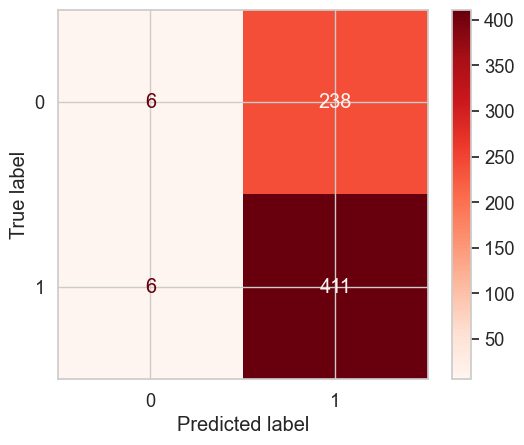

In [38]:
lr = LogisticRegression()
lr.fit(Xtrain_tfidf,ytrain)
p1=lr.predict(Xtest_tfidf)
s1=accuracy_score(ytest,p1)
print("Logistic Regression Accuracy :", "{:.2f}%".format(100*s1))
cm = confusion_matrix(ytest,p1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot(cmap="Reds")
plt.show()

### Multinomial Naive Bayes

Multinomial Naive Bayes Classifier Accuracy : 63.09%


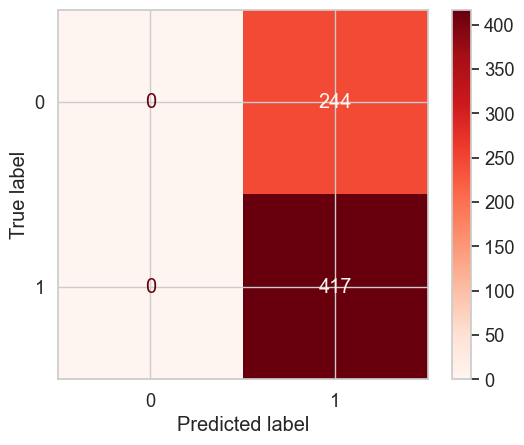

In [39]:
mnb= MultinomialNB()
mnb.fit(Xtrain_tfidf,ytrain)
p2=mnb.predict(Xtest_tfidf)
s2=accuracy_score(ytest,p2)
print("Multinomial Naive Bayes Classifier Accuracy :", "{:.2f}%".format(100*s2))
cm = confusion_matrix(ytest,p2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot(cmap="Reds")
plt.show()

### Linear SVM

C:\Users\Anita Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Linear Support Vector Classifier Accuracy : 60.82%


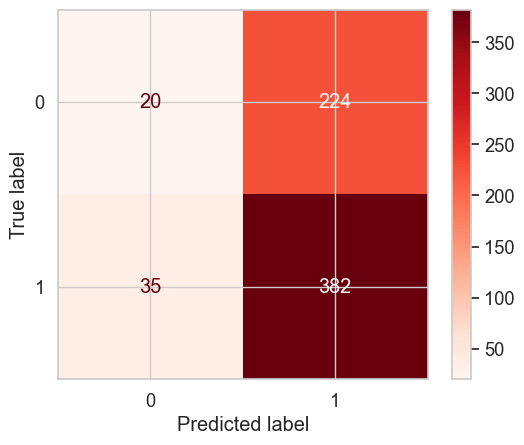

In [40]:
linear_svc = LinearSVC(penalty='l2',loss = 'hinge')
linear_svc.fit(Xtrain_tfidf,ytrain)
p3=linear_svc.predict(Xtest_tfidf)
s3=accuracy_score(ytest,p3)
print("Linear Support Vector Classifier Accuracy :", "{:.2f}%".format(100*s3))
cm = confusion_matrix(ytest,p3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot(cmap="Reds")
plt.show()

### XGboost 

C:\Users\Anita Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBoost Accuracy : 61.88%


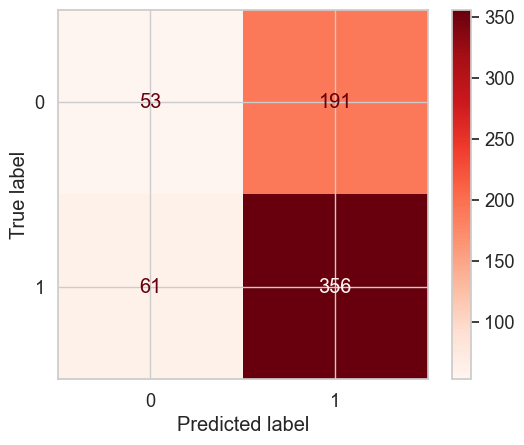

In [41]:
xgbo = XGBClassifier()
xgbo.fit(Xtrain_tfidf,ytrain)
p4=xgbo.predict(Xtest_tfidf)
s4=accuracy_score(ytest,p4)
print("XGBoost Accuracy :", "{:.2f}%".format(100*s4))
cm = confusion_matrix(ytest,p4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot(cmap="Reds")
plt.show()

# **B. Predictive Modelling using Deep Learning** 

In [42]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))
  
  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()

In [43]:
#splitting into train and test
data_copy['facts']=data_copy['facts'].apply(clean_text,lemmatize = False)
#converting target variable to numerical value
data_copy['verdict'] = [ 1 if each == True else 0 for each in data_copy.first_party_winner]
train, test= train_test_split(data_copy, test_size=0.2, random_state=42)
Xtrain, ytrain = train['facts'], train['verdict']
Xtest, ytest = test['facts'], test['verdict']

### LSTM

In [44]:
#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)


Vocabulary of the dataset is :  18862


In [45]:
##create sequences of facts
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)

In [46]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 533


In [47]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 191


In [48]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))


The above calculated number coveres approximately 95.76 % of data


So we can use this number for our maxlen parameter.

In [49]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [50]:
#Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,ytrain,
                                             test_size=0.2,random_state=10)

In [51]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
#     #early_stop = EarlyStopping(monitor='val_accuracy', 
#                                mode='min', 
#                                patience = 2 )
#     #checkpoints= ModelCheckpoint(filepath='./',
#                             monitor="val_accuracy",
#                             verbose=0,
#                             save_best_only=True
#                            )
  #  callbacks = [checkpoints,early_stop]
    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 


In [52]:
D = 64 #embedding dims
epochs = 5
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

----Building the model----
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 191)]             0         
                                                                 
 embedding (Embedding)       (None, 191, 64)           1207232   
                                                                 
 batch_normalization (Batch  (None, 191, 64)           256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 191, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 187, 32)           10272     
                                                                 
 dropout_1 (Dropout)         (None, 187, 32)           0         
                                  

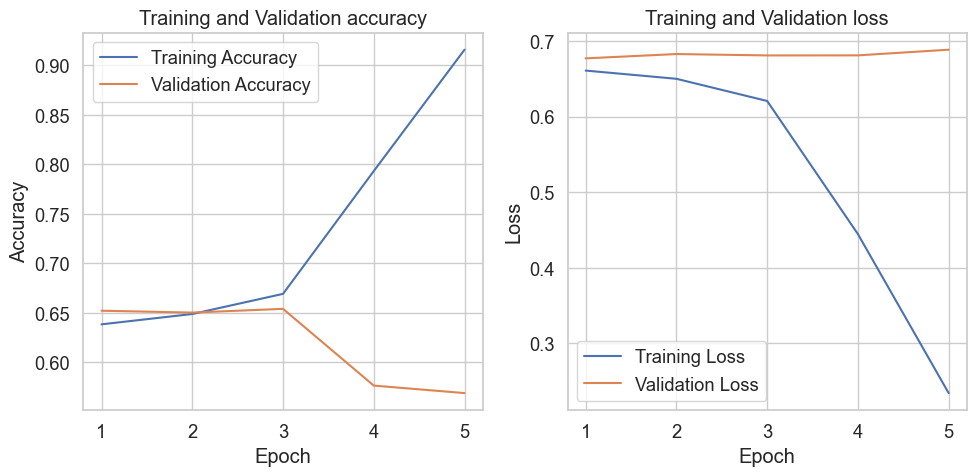

In [53]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [54]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,ytest)
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
21/21 [==============================] - 1s 60ms/step - loss: 0.6653 - accuracy: 0.6021
{'loss': 0.6653146147727966, 'accuracy': 0.6021180152893066}


21/21 [==============================] - 4s 61ms/step


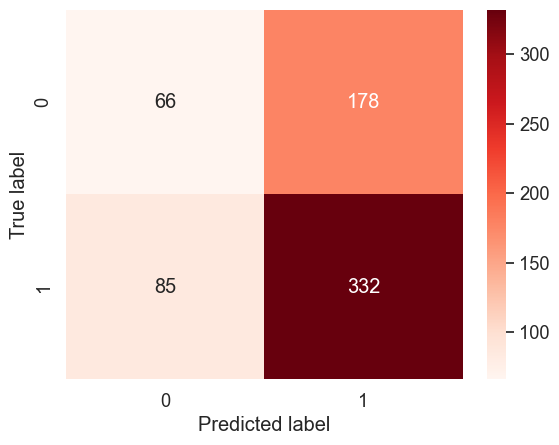

In [55]:
#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Reds')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### BERT


In [56]:
train, test= train_test_split(data_copy, test_size=0.2, random_state=42)
Xtrain, ytrain = train['facts'], train['verdict']
Xtest, ytest = test['facts'], test['verdict']
#splitting the train set into train and validation
Xtrain,Xval,ytrain,yval=train_test_split(Xtrain,ytrain,
                                             test_size=0.2,random_state=10)

In [57]:
#Perform tokenization
# automatically download the vocab used during pretraining or fine-tuning a given model,use from_pretrained() method
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')


In [58]:
#pass our texts to the tokenizer. 
Xtrain_enc = tokenizer(Xtrain.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xval_enc = tokenizer(Xval.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object
Xtest_enc = tokenizer(Xtest.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object




In [59]:
#preparing our datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtrain_enc),
    ytrain
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xval_enc),
    yval
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtest_enc),
    ytest
))

In [60]:
def bert_model(train_dataset,val_dataset,transformer,max_len,epochs):
    print("----Building the model----")
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,),dtype=tf.int32,name = 'attention_mask') #attention mask
    sequence_output = transformer(input_ids,attention_mask)[0]
    cls_token = sequence_output[:, 0, :]
    x = Dense(512, activation='relu')(cls_token)
    x = Dropout(0.1)(x)
    y = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_ids,attention_mask], outputs=y)
    model.summary()
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    r = model.fit(train_dataset.batch(32),batch_size = 32,
                  validation_data = val_dataset.batch(32),epochs = epochs)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(train_dataset.batch(32)))
    print("Validation score:", model.evaluate(val_dataset.batch(32)))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [61]:
transformer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
epochs = 8
max_len = max_seq_len
r,model,n_epochs = bert_model(train_dataset,val_dataset,transformer,max_len,epochs)

----Building the model----
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 191)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 191)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 191, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte          

Epoch 1/8
67/67 [==============================] - 751s 11s/step - loss: 0.7239 - accuracy: 0.6152 - val_loss: 0.6535 - val_accuracy: 0.6522
Epoch 2/8
67/67 [==============================] - 752s 11s/step - loss: 0.6518 - accuracy: 0.6512 - val_loss: 0.6492 - val_accuracy: 0.6522
Epoch 3/8
62/67 [==========================>...] - ETA: 38s - loss: 0.6510 - accuracy: 0.6517

In [ ]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [ ]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(test_dataset.batch(32))
print(dict(zip(model.metrics_names, result)))

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(test_dataset.batch(32))
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Reds')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### 